TRAIN - 骨质疏松: 391, 非骨质疏松: 749, 总样本: 1140
TEST - 骨质疏松: 48, 非骨质疏松: 95, 总样本: 143
VAL - 骨质疏松: 49, 非骨质疏松: 95, 总样本: 144
EXTEST - 骨质疏松: 38, 非骨质疏松: 65, 总样本: 103

========== Epoch 1/5 ==========
TRAIN  | ACC=0.7219  AUC=0.8318 (95%CI 0.8042-0.8571)  Prec=0.5642  Spec=0.6649  Rec=0.8312  F1=0.6722
TEST   | ACC=0.6434  AUC=0.7752 (95%CI 0.6857-0.8553)  Prec=0.4810  Spec=0.5684  Rec=0.7917  F1=0.5984
VAL    | ACC=0.6181  AUC=0.7310 (95%CI 0.6413-0.8151)  Prec=0.4605  Spec=0.5684  Rec=0.7143  F1=0.5600
EXTEST | ACC=0.5146  AUC=0.8012 (95%CI 0.7155-0.8777)  Prec=0.4318  Spec=0.2308  Rec=1.0000  F1=0.6032


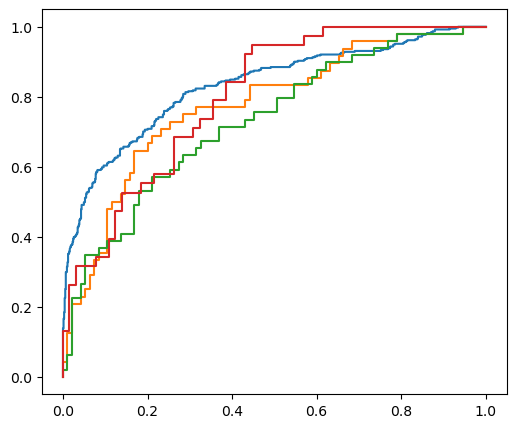

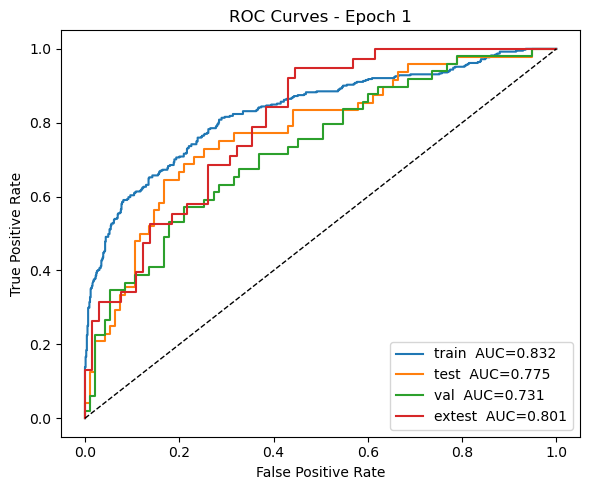


========== Epoch 2/5 ==========
TRAIN  | ACC=0.8289  AUC=0.9314 (95%CI 0.9168-0.9446)  Prec=0.6960  Spec=0.7971  Rec=0.8900  F1=0.7811
TEST   | ACC=0.7483  AUC=0.8265 (95%CI 0.7485-0.8899)  Prec=0.6034  Spec=0.7579  Rec=0.7292  F1=0.6604
VAL    | ACC=0.7153  AUC=0.7929 (95%CI 0.7063-0.8658)  Prec=0.5606  Spec=0.6947  Rec=0.7551  F1=0.6435
EXTEST | ACC=0.7087  AUC=0.8308 (95%CI 0.7352-0.9115)  Prec=0.5870  Spec=0.7077  Rec=0.7105  F1=0.6429


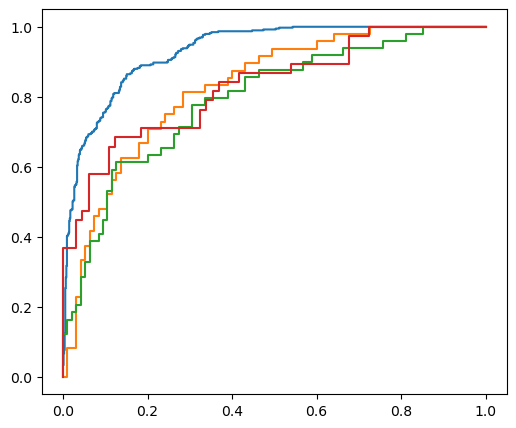

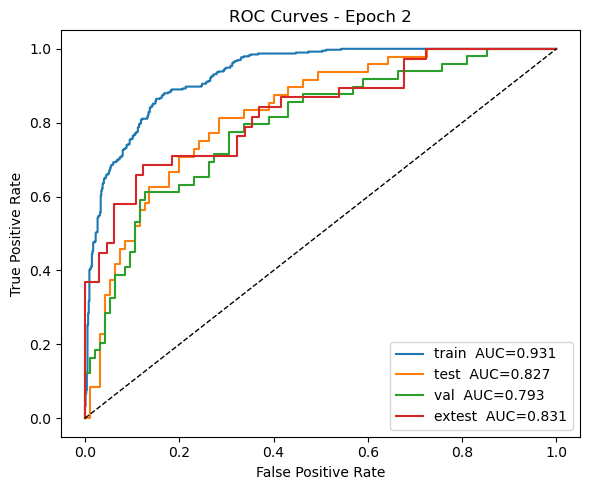


========== Epoch 3/5 ==========
TRAIN  | ACC=0.8982  AUC=0.9727 (95%CI 0.9638-0.9803)  Prec=0.8090  Spec=0.8865  Rec=0.9207  F1=0.8612
TEST   | ACC=0.6853  AUC=0.7487 (95%CI 0.6687-0.8219)  Prec=0.5319  Spec=0.7684  Rec=0.5208  F1=0.5263
VAL    | ACC=0.7500  AUC=0.7914 (95%CI 0.7072-0.8695)  Prec=0.6182  Spec=0.7789  Rec=0.6939  F1=0.6538
EXTEST | ACC=0.7282  AUC=0.8255 (95%CI 0.7398-0.8976)  Prec=0.6923  Spec=0.8769  Rec=0.4737  F1=0.5625


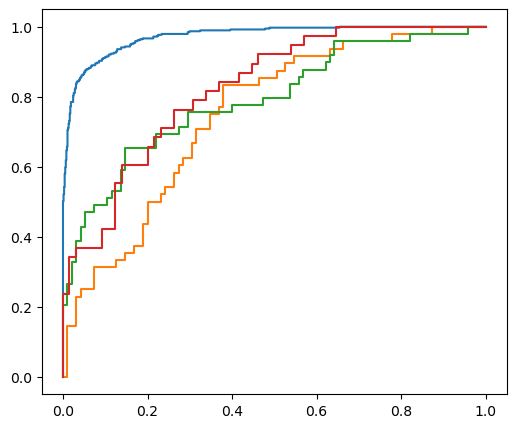

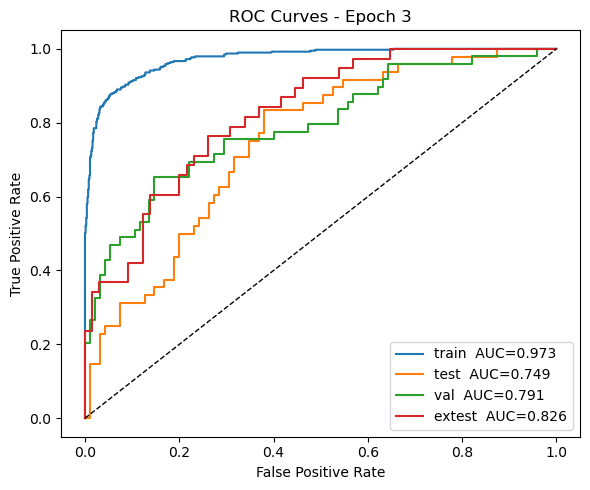


========== Epoch 4/5 ==========
TRAIN  | ACC=0.9307  AUC=0.9840 (95%CI 0.9775-0.9895)  Prec=0.9286  Spec=0.9653  Rec=0.8645  F1=0.8954
TEST   | ACC=0.7133  AUC=0.7765 (95%CI 0.6990-0.8468)  Prec=0.6061  Spec=0.8632  Rec=0.4167  F1=0.4938
VAL    | ACC=0.7639  AUC=0.8292 (95%CI 0.7553-0.8964)  Prec=0.6829  Spec=0.8632  Rec=0.5714  F1=0.6222
EXTEST | ACC=0.8058  AUC=0.8575 (95%CI 0.7770-0.9280)  Prec=0.8462  Spec=0.9385  Rec=0.5789  F1=0.6875


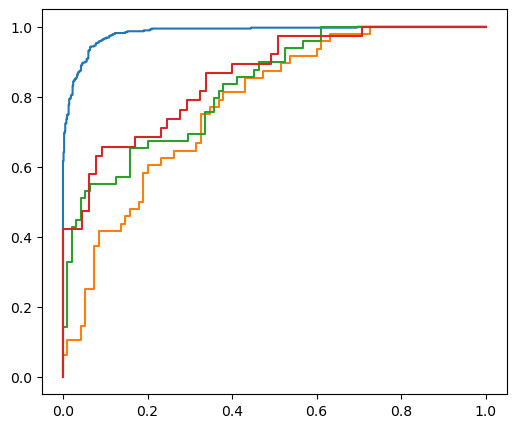

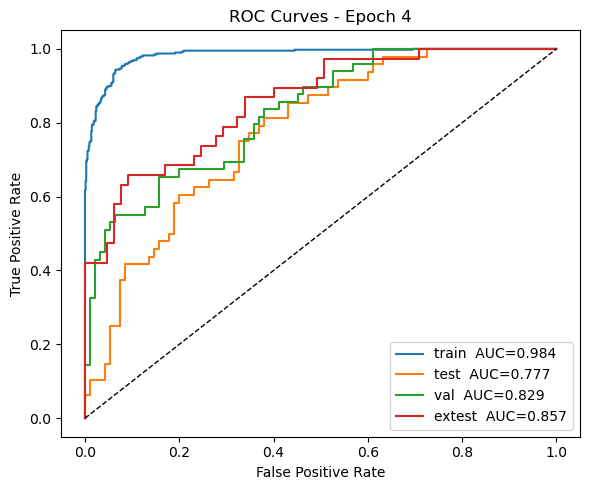


========== Epoch 5/5 ==========
TRAIN  | ACC=0.9605  AUC=0.9935 (95%CI 0.9899-0.9964)  Prec=0.9553  Spec=0.9773  Rec=0.9284  F1=0.9416
TEST   | ACC=0.6993  AUC=0.7827 (95%CI 0.7024-0.8564)  Prec=0.5758  Spec=0.8526  Rec=0.3958  F1=0.4691
VAL    | ACC=0.7361  AUC=0.7712 (95%CI 0.6783-0.8524)  Prec=0.6486  Spec=0.8632  Rec=0.4898  F1=0.5581
EXTEST | ACC=0.7282  AUC=0.8571 (95%CI 0.7784-0.9235)  Prec=0.7778  Spec=0.9385  Rec=0.3684  F1=0.5000


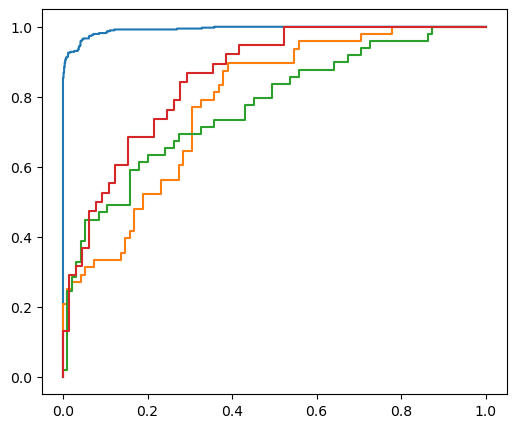

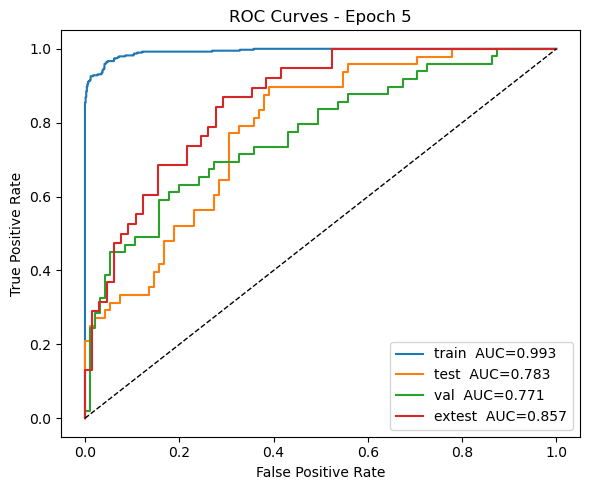


所有 epoch 的评估指标与 95% CI 已保存到 auc_ci_per_epoch.csv


In [1]:
# train_osteoporosis_dual_full.py
import os
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    precision_recall_fscore_support, recall_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ------------------ 全局配置 ------------------
device = torch.device("cpu")
batch_size = 4
num_epochs = 5
learning_rate = 1e-4
image_size = 224

base_path = "D:/骨密度数据集"
table_paths = {
    'train':  os.path.join(base_path, 'train_table.xlsx'),
    'test':   os.path.join(base_path, 'test_table.xlsx'),
    'val':    os.path.join(base_path, 'val_table.xlsx'),
    'extest': os.path.join(base_path, 'extest_table.xlsx')
}
image_dirs = {
    'train':  os.path.join(base_path, 'train'),
    'test':   os.path.join(base_path, 'test'),
    'val':    os.path.join(base_path, 'val'),
    'extest': os.path.join(base_path, 'extest')
}

# ------------------ 工具函数 ------------------
def load_clean_table(path, image_dir):
    df = pd.read_excel(path)
    if '编号' in df.columns:
        df.rename(columns={'编号': 'ID'}, inplace=True)
    df['ID'] = df['ID'].astype(str)
    df = df[df['ID'].apply(
        lambda pid: (
            os.path.isfile(os.path.join(image_dir, str(pid), 'zw.dcm')) and
            os.path.isfile(os.path.join(image_dir, str(pid), 'cw.dcm'))
        )
    )].reset_index(drop=True)
    counts = df['是否骨质疏松'].value_counts()
    return df, counts

class BoneDualDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = str(row['ID'])
        label = int(row['是否骨质疏松'])

        def load_dcm(filename):
            dcm_path = os.path.join(self.image_dir, pid, filename)
            ds = pydicom.dcmread(dcm_path)
            img = ds.pixel_array.astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            if img.ndim == 2:
                img = np.stack([img] * 3, axis=0)
            img = torch.tensor(img).unsqueeze(0)
            img = nn.functional.interpolate(img, size=(image_size, image_size)).squeeze(0)
            if self.transform:
                img = self.transform(img)
            return img

        zw = load_dcm('zw.dcm')
        cw = load_dcm('cw.dcm')
        return zw, cw, label

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x)
])

# ------------------ 数据加载 ------------------
stats = {}
for split in ['train', 'test', 'val', 'extest']:
    df, counts = load_clean_table(table_paths[split], image_dirs[split])
    stats[split] = {'df': df, 'counts': counts}
    print(f"{split.upper()} - 骨质疏松: {counts.get(1,0)}, 非骨质疏松: {counts.get(0,0)}, 总样本: {len(df)}")

loaders = {}
for split in ['train', 'test', 'val', 'extest']:
    dataset = BoneDualDataset(stats[split]['df'], image_dirs[split], transform=transform)
    loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'), num_workers=0)

# ------------------ 模型 ------------------
class DualResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.zw_net = models.resnet18(pretrained=True)
        self.zw_net.fc = nn.Linear(self.zw_net.fc.in_features, 1)
        self.cw_net = models.resnet18(pretrained=True)
        self.cw_net.fc = nn.Linear(self.cw_net.fc.in_features, 1)

    def forward(self, zw, cw):
        out_zw = self.zw_net(zw).squeeze(1)
        out_cw = self.cw_net(cw).squeeze(1)
        return (out_zw + out_cw) / 2

model = DualResNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ------------------ 评估 & Bootstrap CI ------------------
def bootstrap_auc_ci(y_true, y_score, n_boot=2000, ci=0.95, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    aucs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
    aucs = np.array(aucs)
    lower, upper = np.percentile(aucs, [(1 - ci) / 2 * 100, (1 + ci) / 2 * 100])
    return roc_auc_score(y_true, y_score), lower, upper

def evaluate(loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for zw, cw, labels in loader:
            zw, cw, labels = zw.to(device), cw.to(device), labels.float().to(device)
            outputs = model(zw, cw)
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels, all_probs = np.array(all_labels), np.array(all_probs)
    if len(all_labels) == 0:
        return None
    preds = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_labels, preds)
    auc = roc_auc_score(all_labels, all_probs)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, preds, average='binary', zero_division=0)
    specificity = recall_score(1 - all_labels, 1 - preds, average='binary', zero_division=0)
    return acc, auc, precision, specificity, recall, f1, all_labels, all_probs

# ------------------ 训练循环（带评估 & CI） ------------------
metrics_ci_log = []

for epoch in range(1, num_epochs + 1):
    # ---------- 1. 训练 ----------
    model.train()
    for zw, cw, labels in loaders['train']:
        zw, cw, labels = zw.to(device), cw.to(device), labels.float().to(device)
        outputs = model(zw, cw)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ---------- 2. 评估 ----------
    print(f"\n========== Epoch {epoch}/{num_epochs} ==========")
    plt.figure(figsize=(6, 5))
    epoch_row = {'epoch': epoch}
    for split in ['train', 'test', 'val', 'extest']:
        loader = loaders[split]
        if len(loader.dataset) == 0:
            continue
        res = evaluate(loader)
        if res is None:
            continue
        acc, auc, prec, spec, rec, f1, y_true, y_score = res
        auc_obs, lower, upper = bootstrap_auc_ci(y_true, y_score)
        # 控制台打印
        print(f"{split.upper():6} | "
              f"ACC={acc:.4f}  AUC={auc:.4f} (95%CI {lower:.4f}-{upper:.4f})  "
              f"Prec={prec:.4f}  Spec={spec:.4f}  Rec={rec:.4f}  F1={f1:.4f}")
        # 画 ROC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{split} AUC={auc:.3f} [{lower:.3f}-{upper:.3f}]")
        # 记录 CSV
        epoch_row.update({
            f'{split}_acc': acc, f'{split}_auc': auc,
            f'{split}_ci_lower': lower, f'{split}_ci_upper': upper,
            f'{split}_prec': prec, f'{split}_spec': spec,
            f'{split}_rec': rec, f'{split}_f1': f1
        })

        # ---------- 3. 画图（仅显示 AUC） ----------
    plt.figure(figsize=(6, 5))
    for split in ['train', 'test', 'val', 'extest']:
        loader = loaders[split]
        if len(loader.dataset) == 0:
            continue
        res = evaluate(loader)
        if res is None:
            continue
        acc, auc, prec, spec, rec, f1, y_true, y_score = res
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{split}  AUC={auc:.3f}")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - Epoch {epoch}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# 保存所有 epoch 结果
pd.DataFrame(metrics_ci_log).to_csv('auc_ci_per_epoch.csv', index=False, encoding='utf-8-sig')
print("\n所有 epoch 的评估指标与 95% CI 已保存到 auc_ci_per_epoch.csv")

In [5]:
# =================== 追加代码 ===================
import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

def save_single_view_preds(model_net, split_name, view='zw'):
    model.eval()
    loader = loaders[split_name]
    ids = stats[split_name]['df']['ID'].astype(str).tolist()
    all_labels, all_probs = [], []

    with torch.no_grad():
        for zw, cw, labels in loader:               # (B, C, H, W)
            if view == 'zw':
                img = zw.to(device)                 # (B, C, H, W)
            else:
                img = cw.to(device)                 # (B, C, H, W)
            labels = labels.float().to(device)

            # 网络输出
            logits = model_net(img).squeeze(1)      # (B,)
            probs = torch.sigmoid(logits)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 构造结果
    preds = (np.array(all_probs) >= 0.5).astype(int)
    out_df = pd.DataFrame({
        'ID': ids,
        'true_label': all_labels,
        'pred_prob': all_probs,
        'pred_label': preds
    })
    out_path = f"{view}_pred_{split_name}.csv"
    out_df.to_csv(out_path, index=False, encoding='utf-8-sig')
    print(f"已保存：{out_path}")

# 提取正位与侧位网络
zw_net = model.zw_net
cw_net = model.cw_net

# 分别对 4 个 split 生成 8 份预测文件
for split in ['train', 'test', 'val', 'extest']:
    save_single_view_preds(zw_net, split, view='zw')
    save_single_view_preds(cw_net, split, view='cw')

已保存：zw_pred_train.csv
已保存：cw_pred_train.csv
已保存：zw_pred_test.csv
已保存：cw_pred_test.csv
已保存：zw_pred_val.csv
已保存：cw_pred_val.csv
已保存：zw_pred_extest.csv
已保存：cw_pred_extest.csv
